In [1]:
import gym
import numpy as np

In [2]:
env = gym.make('Blackjack-v0')

In [3]:
print(env.observation_space)
print((env.action_space))


Tuple(Discrete(32), Discrete(11), Discrete(2))
Discrete(2)


In [4]:
for i in range(5):
    state = env.reset()

    while True:
        print(state)
        action = env.action_space.sample()
        obs,reward,done,info = env.step(action)
        if done:
            print(obs, reward)
            break
                

(14, 10, False)
(14, 10, False) -1.0
(20, 4, True)
(20, 4, True)
(29, 4, False) -1
(8, 10, False)
(8, 10, False) -1.0
(20, 4, False)
(30, 4, False) -1
(20, 9, False)
(27, 9, False) -1


In [5]:
def generate_episode(bj_env):
    state = bj_env.reset()
    episode = []
    while True:
        prob = [0.8,0.2] if state[0] > 18 else [0.2,0.8]
        action = np.random.choice(np.array(2),p = prob)
        next_state, reward, done, info = bj_env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

            
        
        

In [6]:
from collections import defaultdict
import sys

In [ ]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=0.9):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        print(i_episode)
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            print(states, actions, rewards)
            print('disc',discounts)
            print(state)
            print('R:',returns_sum[state][actions[i]])
            N[state][actions[i]] += 1.0
            print('N:',N[state][actions[i]])
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
            print('Q:',Q[state][actions[i]])
            
    return Q

In [ ]:
Q = mc_prediction_q(env, 5, generate_episode)
print(Q)

In [29]:
def mc_prediction1(env, n_episodes,generate_episode, gamma = 0.9):
    
    cum_rewards = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    for i_ep in range(1, n_episodes+1):
        
        if i_ep % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_ep, n_episodes), end="")
            sys.stdout.flush()
            
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode) # all states for al time steps put together in a tuple, 
                                                #same for action and reward
        
        # NOw we want to calc. cumulative discounted sum of rewards, for that we need gamma
        
        #step 1: create an array of discount multipliers
        
        discount = np.array([gamma**i for i in range(len(rewards)+1)])
        # if gamma is 0.9 this will creat an array [1,0.9,0.81,..]
        
        for i,state in enumerate(states):
            # multiplying each reward after action i by discount factor gamma**i and summing them
            cum_rewards[state][actions[i]] += sum(rewards[i:]*discount[:-(i+1)])
            # count number of times the state action pair occoured in this episode
            N[state][actions[i]] += 1
            
            # taking average of all cumulative rewards for al visits to the state action pair for this episode
            
            Q[state][actions[i]] = cum_rewards[state][actions[i]] / N[state][actions[i]]
            
    return Q      
            
    

In [30]:
Q = mc_prediction1(env, 500000, generate_episode, gamma = 0.9)

Episode 500000/500000.

In [31]:
V_to_plot = dict((k,(k[0]>18)*(np.dot([0.8, 0.2],v)) + (k[0]<=18)*(np.dot([0.2, 0.8],v))) \
         for k, v in Q.items())

In [32]:
print(V_to_plot)

{(14, 2, False): -0.4920900482909552, (21, 10, True): 0.6778102706806561, (19, 3, False): 0.18244207524484385, (7, 10, False): -0.5020680192784661, (16, 10, False): -0.6516589816549906, (21, 10, False): 0.5164464692482917, (17, 10, False): -0.6461566561548617, (13, 4, False): -0.43508401516269124, (14, 4, False): -0.4583199447739212, (15, 8, True): -0.28961307936507963, (18, 8, True): -0.16156140350877252, (16, 8, False): -0.5820956975628141, (15, 4, False): -0.4983500818788585, (21, 4, False): 0.5116451016635859, (13, 10, False): -0.5717743414689929, (14, 10, False): -0.6043839722961932, (18, 10, False): -0.6411014461622744, (11, 10, False): -0.23909937811241289, (13, 6, False): -0.40890582511961804, (14, 1, False): -0.6910969876212808, (18, 1, False): -0.6858190707799273, (6, 10, False): -0.48790760903118535, (8, 10, False): -0.4809774122654636, (21, 8, True): 0.7455905194805195, (9, 1, False): -0.49888013011200905, (19, 1, False): -0.2696270694540913, (20, 10, False): 0.175688254164

In [33]:
import pandas as pd
df = pd.DataFrame.from_dict(data = V_to_plot,orient = 'index')
df

,0
"(14, 2, False)",-0.492090
"(21, 10, True)",0.677810
"(19, 3, False)",0.182442
"(7, 10, False)",-0.502068
"(16, 10, False)",-0.651659
"(21, 10, False)",0.516446
"(17, 10, False)",-0.646157
"(13, 4, False)",-0.435084
"(14, 4, False)",-0.458320
"(15, 8, True)",-0.289613


In [34]:
dfQ = pd.DataFrame.from_dict(data = Q,orient = 'index')
dfQ

,0,1
"(14, 2, False)",-0.317241,-0.535802
"(21, 10, True)",0.889627,-0.169456
"(19, 3, False)",0.418721,-0.762672
"(7, 10, False)",-0.605782,-0.476140
"(16, 10, False)",-0.576584,-0.670428
"(21, 10, False)",0.895558,-1.000000
"(17, 10, False)",-0.455700,-0.693771
"(13, 4, False)",-0.247588,-0.481958
"(14, 4, False)",-0.155556,-0.534011
"(15, 8, True)",-0.611111,-0.209239


In [27]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()


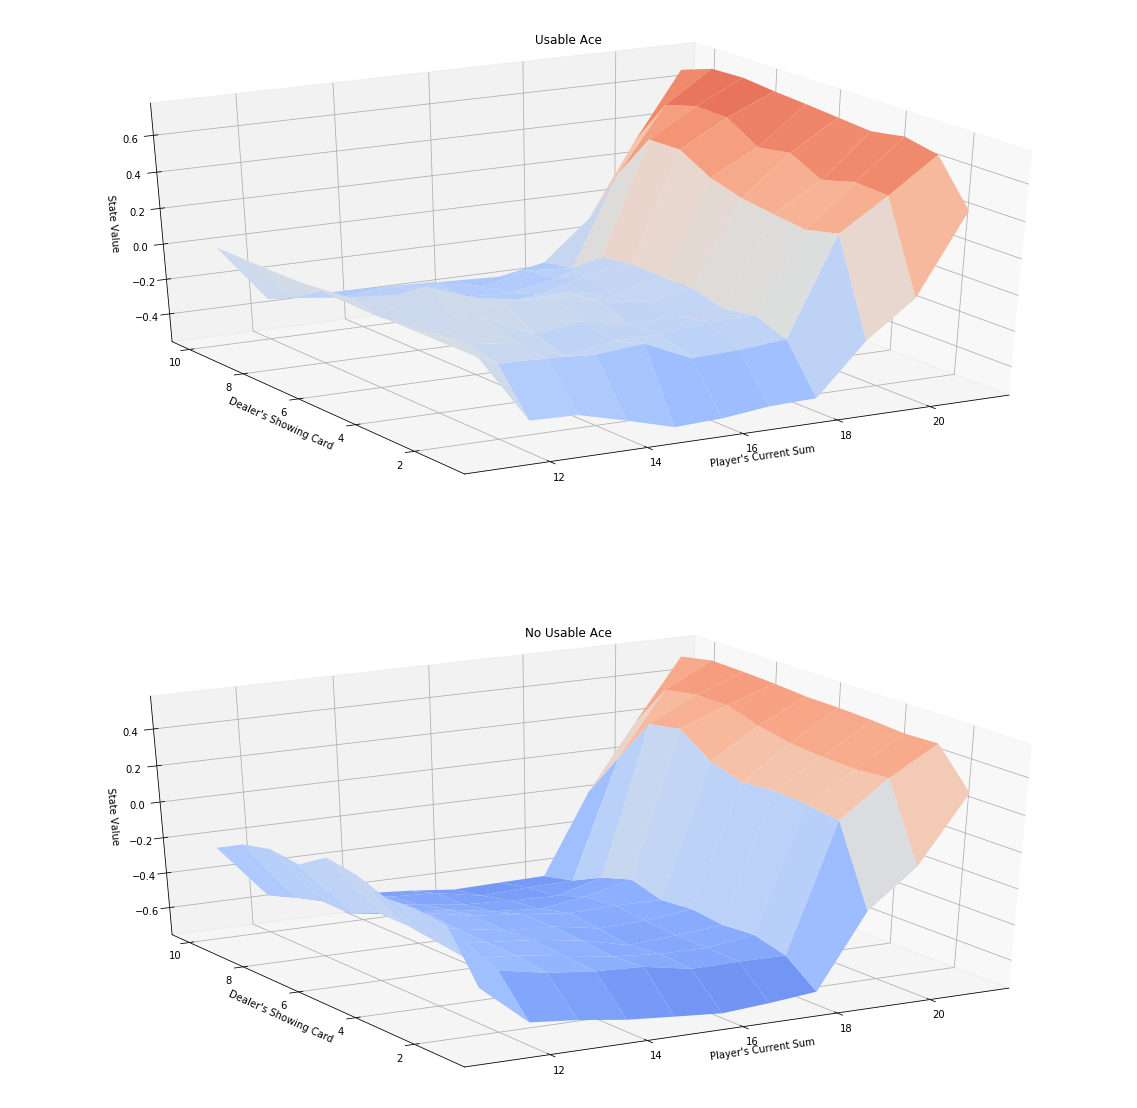

In [35]:
plot_blackjack_values(V_to_plot)

## MC Control

In [42]:
def get_probs(Q_s, epsilon, nA):
    policy_s = np.ones(nA)* epsilon/nA
    best_action = np.argmax(Q_s)
    policy_s[best_action] = 1 - epsilon + ( epsilon/nA )
    return policy_s
    

In [44]:
Q_s = [1,5,7,3]
get_probs(Q_s,0.9,4)

array([0.225, 0.225, 0.325, 0.225])

In [62]:
def generate_episode_Q(env, epsilon, nA):
    state  = env.reset()
    episode = []
    while True:
        action = np.random.choice(np.arange(nA),p = get_probs(Q[state],epsilon,nA) if state in Q else env.action_space.sample())
    
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

    
    

In [66]:
def update_Q(episode,alpha,gamma ):
    
    states, actions, rewards = zip(*episode)
    
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        prev_Q = Q[state][actions[i]]
        Q[state][actions[i]] = prev_Q + alpha*( sum(rewards[i:] * discounts[:-(i+1)]) - prev_Q) 
    
    return Q
        
    

In [75]:
def mc_control(env, num_episodes, alpha = 0.1,   gamma = 0.9,  eps_initial = 1, eps_decay =  0.9999, eps_min = 0.05):
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    epsilon = eps_initial
    for ne in range(1,num_episodes + 1):
        if ne % 1000 == 0:
            print("\rEpisode {}/{}.".format(ne, num_episodes), end="")
            sys.stdout.flush()
        epsilon = max(epsilon * eps_decay, eps_min)
        
        episode = generate_episode_Q(env, epsilon, nA)
        
        Q = update_Q(episode,alpha,gamma )
        
        policy = dict( (k,np.argmax(v)) for k,v in Q.items())
        
    return policy,Q
    
    

In [76]:
policy, Q = mc_control(env, 500000, 0.02)

Episode 500000/500000.

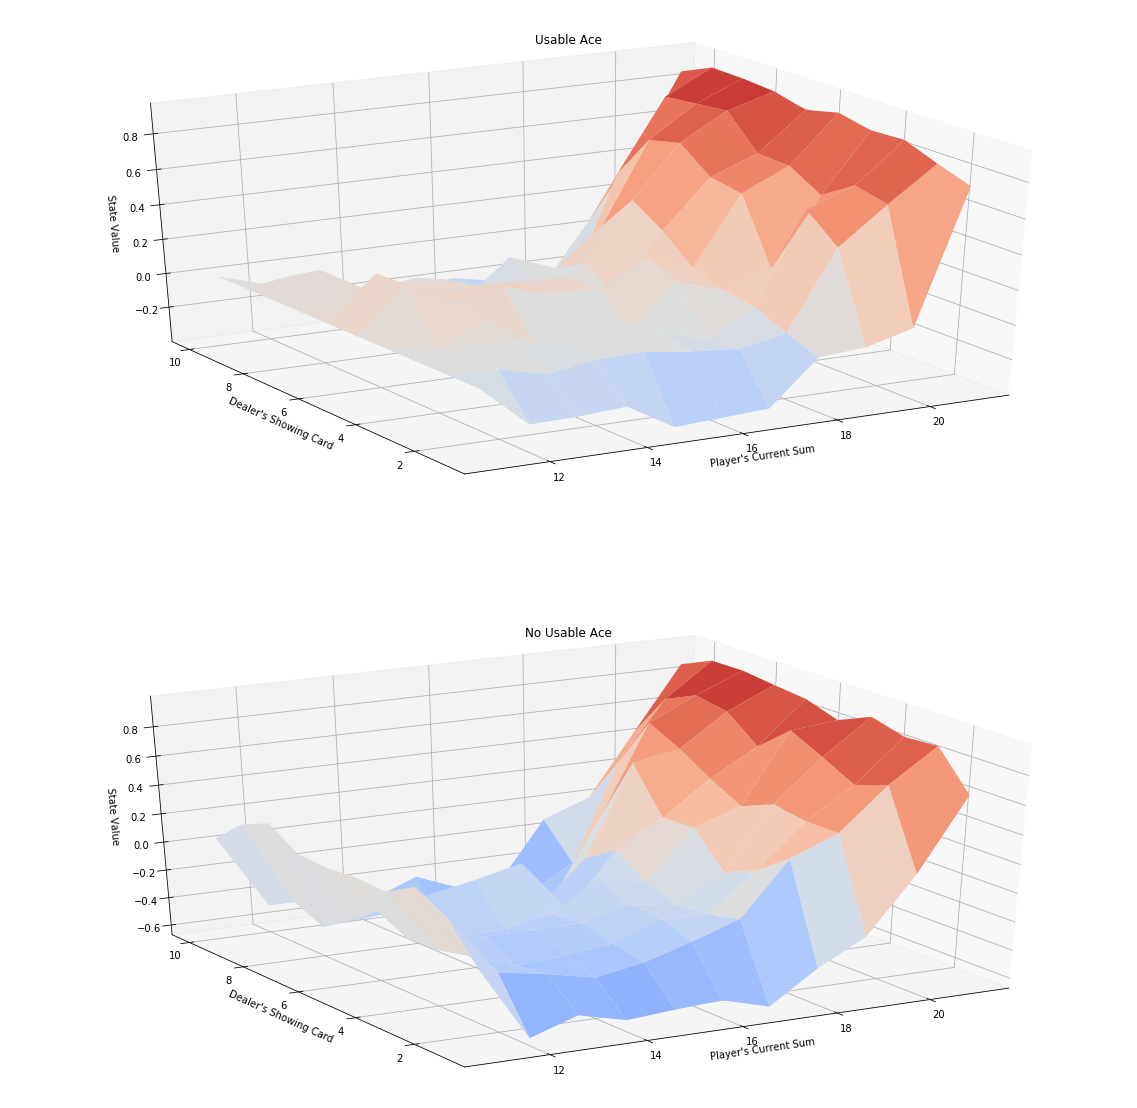

In [77]:
V = dict((k,np.max(v)) for k,v in Q.items())

plot_blackjack_values(V)

In [78]:
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('Pastel2', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

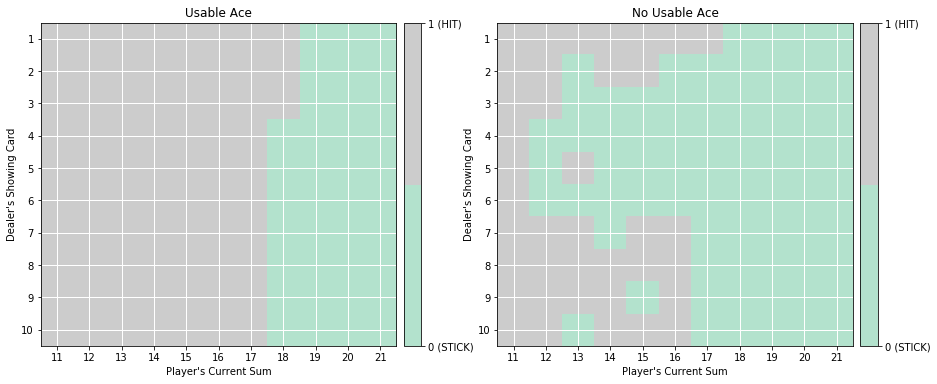

In [79]:
plot_policy(policy)